# Using `mofax` with `MFMF`

In [1]:
import pyro
import mfmf
import torch
import mofax as mfx
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas as pd
# import numpy as np
# import anndata
# from sklearn.decomposition import FactorAnalysis
# import math
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from mofapy2.run.entry_point import entry_point
import pandas as pd
import numpy as np

N_FACTORS = 6

### Train the `MFMF` model

In [7]:
# Initialize the model
optimizer = pyro.optim.Adam({"lr": 0.05, "betas": (0.90, 0.999)})
early = mfmf.loss.EarlyStoppingLoss(
    loss_fn=pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True),
    epochs=100,
    report_after_n_epochs=1,
    min_decrease=0.01,
    max_flat_intervals=3,
)

fmh = mfmf.model.FactorModel(
    optimizer=optimizer,
    loss=early,
    device="cuda",
    dtype=torch.float32,
)

# Add the included CLL data containing 4 views to the model
imp = mfmf.importer.Importer()
cll_data = imp.load_CLL()
# fmh.add_MultiView(cll_data)
fmh.add_View("drugs", cll_data["drugs"])

# Artificially define two covariate groups
fmh.add_covariates(
    level="obs", 
    flavour="unordered", 
    covariates={
        "control": fmh.views["drugs"].obs_names[:50], 
        "treatment": fmh.views["drugs"].obs_names[:50]
    }
)

# Preview the model
# fmh.fit(
#     n_factors=N_FACTORS, 
#     likelihood=pyro.distributions.Normal,
#     feature_reg="spike-and-slab",
#     dry_run=True
# )

# Train the model
fmh.fit(
    n_factors=N_FACTORS, 
    likelihood=pyro.distributions.Normal,
    feature_reg="spike-and-slab",
    dry_run=False
)

[iteration   1] last ELBO in interval: 155.331  |  -1.11 %  |    
[iteration   2] last ELBO in interval: 151.736  |  -3.40 %  |  - 2.31 %  
[iteration   3] last ELBO in interval: 151.670  |  -3.44 %  |  - 0.04 %  |  FLAT INTERVAL
[iteration   4] last ELBO in interval: 148.660  |  -5.36 %  |  - 1.98 %  
[iteration   5] last ELBO in interval: 141.381  |  -9.99 %  |  - 4.90 %  
[iteration   6] last ELBO in interval: 134.049  |  -14.66 %  |  - 5.19 %  
[iteration   7] last ELBO in interval: 128.118  |  -18.43 %  |  - 4.42 %  
[iteration   8] last ELBO in interval: 115.908  |  -26.21 %  |  - 9.53 %  
[iteration   9] last ELBO in interval: 108.114  |  -31.17 %  |  - 6.72 %  
[iteration  10] last ELBO in interval:  96.448  |  -38.60 %  |  -10.79 %  
[iteration  11] last ELBO in interval:  95.967  |  -38.90 %  |  - 0.50 %  |  FLAT INTERVAL
[iteration  12] last ELBO in interval:  82.465  |  -47.50 %  |  -14.07 %  
[iteration  13] last ELBO in interval:  86.270  |  -45.08 %  |  + 4.61 %  |  FLAT

### Train the `MOFA` model
Conventiently, we can use the previously trained model to export the provided CLL data in a tidy format which can be ingested by `MOFA`.

In [3]:
data_for_mofa = fmh.get_data(format="tidy")
data_for_mofa.head(3)


,sample,view,feature,value,group
0,H107,drugs,D_172_4,0.023639,control
1,H270,drugs,D_172_4,0.073599,control
2,H218,drugs,D_172_4,NaN,control


In [4]:
# initialise the entry point
ent = entry_point()

# add the prepared tidy data to the model
ent.set_data_df(data_for_mofa)

# set the same options as for the MFMF model
ent.set_model_options(
    factors = N_FACTORS, 
    spikeslab_weights = True, 
    ard_factors = True,
    ard_weights = True
)

ent.set_train_options(
    iter = 1000, 
    convergence_mode = "fast", 
    startELBO = 1, 
    freqELBO = 1, 
    gpu_mode = True, 
    verbose = False, 
    seed = 1
)

ent.build()

ent.run()

ent.save(outfile="./Using_mofax_with_MFMF.hdf5")



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='control' view='drugs' with N=50 samples and D=310 features...
Loaded group='treatment' view='drugs' with N=150 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weight

### Visualising both models using `mofax`

In [5]:
mofa_model = mfx.mofa_model("./Using_mofax_with_MFMF.hdf5", mode="r")
mfmf_model = fmh

for m in [mofa_model, mfmf_model]:
    
    print(f"""\
    Cells: {m.shape[0]}
    Features: {m.shape[1]}
    Groups of cells: {', '.join(m.groups)}
    Views: {', '.join(m.views)}
    """)


    Cells: 200
    Features: 310
    Groups of cells: control, treatment
    Views: drugs
    


AttributeError: 'View' object has no attribute 'shape'

In [ ]:
# Works but has different order
for m in [mofa_model, mfmf_model]:
    
    print(m.get_weights(df=True).sort_index().iloc[:3,:5])

         Factor1   Factor2   Factor3   Factor4   Factor5
ABI3BP -0.267245  0.022538 -0.006052  0.015696 -0.017918
ACTN2  -0.011973  0.333679 -0.005463  0.019517  0.042556
ANK2    0.634001 -0.020961 -0.006360 -0.112291 -0.531666
         Factor1   Factor2   Factor3   Factor4   Factor5
ABI3BP  0.093858 -0.000073  0.223261 -0.406886  0.305330
ACTN2   0.122497  0.000696  0.302662 -0.392817  0.219149
ANK2    0.113812  0.001687  0.253315 -0.396557  0.288116


<AxesSubplot:xlabel='Feature rank', ylabel='Factor1 weight'>

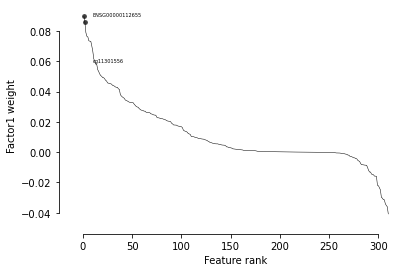

In [ ]:
mfx.plot_weights_ranked(
    mofa_model, 
    factor=0, 
    n_features=3,
)

<AxesSubplot:xlabel='Feature rank', ylabel='Factor1 weight'>

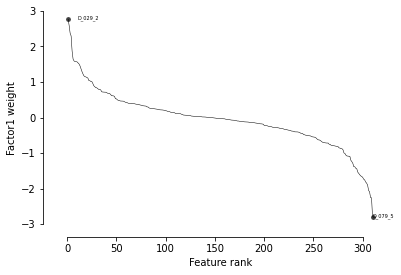

In [ ]:
mfx.plot_weights_ranked(
    mfmf_model, 
    factor=0, 
    n_features=3,
)

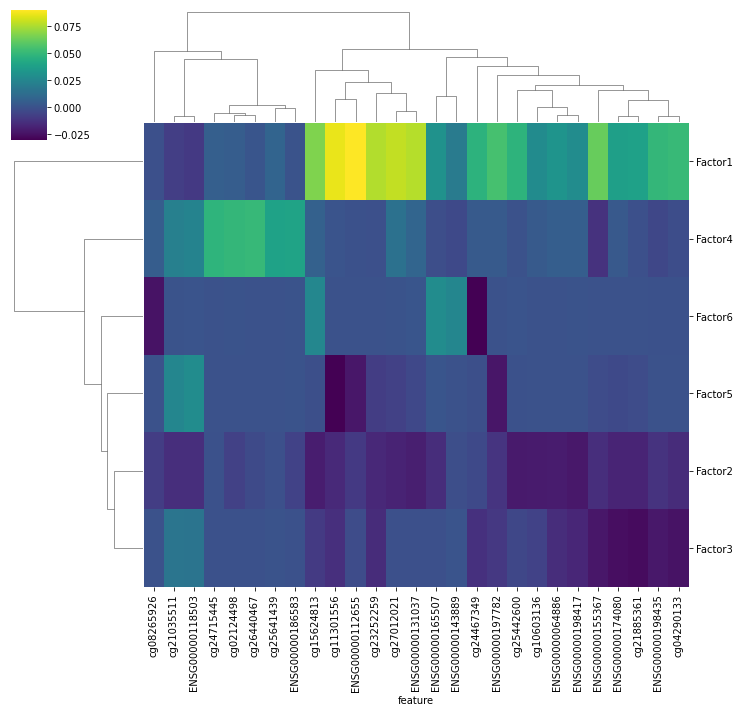

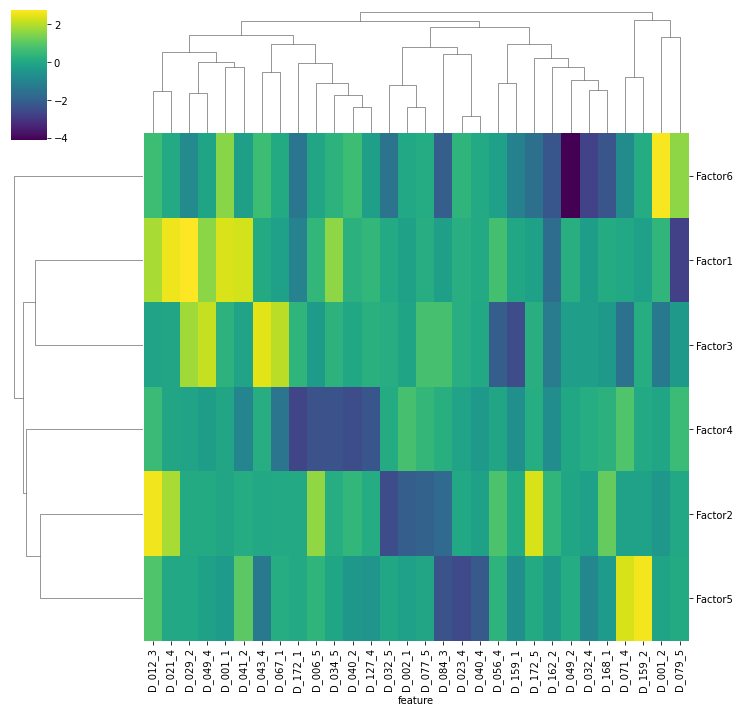

In [ ]:
mfx.plot_weights_heatmap(
    mofa_model, 
    n_features=5, 
    factors=range(0, N_FACTORS), 
    cmap="viridis", 
    cluster_factors=True
)

mfx.plot_weights_heatmap(
    mfmf_model, 
    n_features=5, 
    factors=range(0, N_FACTORS), 
    cmap="viridis", 
    cluster_factors=True
)

In [ ]:
fmh.render_model()

KeyError: 'drugs_all_features'